In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import scipy
import ipynb.fs
import pandas as pd

from ipynb.fs.defs.BCI_COMP_IV_functions import (extractInfo, featureExtraction, createFilterBank,
                                                testWindowLength, testClassifier, testFrequencyBand,
                                                testWindowStartTime,testWindowStartTime_Length, startRunningClassifier,
                                                tuneModelHyperParams)


In [2]:
dataD = scipy.io.loadmat("BCICIV_1calib_1000Hz_mat/BCICIV_calib_ds1d_1000Hz.mat")

dataD["cnt"] = 0.1 * dataD["cnt"].astype(float)

eeg = dataD["cnt"].T
nChannels, nSamples = eeg.shape

motionIntentComp, idleStateComp = [0,-1], [0,-2]

calibDataStore, testData_motionIntent, _ = featureExtraction(dataD,0.7, motionIntentComp, idleStateComp)

calibData_idle_motionIntent, testData_idle_motionIntent, W_idle_motionIntent  = featureExtraction(dataD,0.7,motionIntentComp, idleStateComp,ExtractionType="idle_motionIntent")


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Base Classifiers for detecting Idle State (no resampling)

In [3]:

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import roc_curve, auc, accuracy_score


ldaModel = LDA()
SVMmodel = SVC(probability=True,class_weight="balanced")
logRegModel = LogisticRegression(class_weight="balanced")


In [4]:
nCols = len(calibData_idle_motionIntent.columns)

print("Cross Validation Score")
print("-----------------------")
print("LDA: ",np.mean(cross_val_score(ldaModel,calibData_idle_motionIntent.iloc[:,:nCols-1], calibData_idle_motionIntent.iloc[:,nCols-1],cv=5)))
print("Logistic Regression: ",np.mean(cross_val_score(logRegModel,calibData_idle_motionIntent.iloc[:,:nCols-1], calibData_idle_motionIntent.iloc[:,nCols-1],cv=5)))
print("SVM: ",np.mean(cross_val_score(SVMmodel,calibData_idle_motionIntent.iloc[:,:nCols-1], calibData_idle_motionIntent.iloc[:,nCols-1],cv=5)))
print()


Cross Validation Score
-----------------------
LDA:  0.9678571428571427
Logistic Regression:  0.9535714285714286
SVM:  0.95



### Tuned Classifiers for detecting Idle State (no resampling)

In [5]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')


In [6]:
bestMods = tuneModelHyperParams(calibData_idle_motionIntent.iloc[:,:nCols-1], calibData_idle_motionIntent.iloc[:,nCols-1],testData_idle_motionIntent.iloc[:,:nCols-1], testData_idle_motionIntent.iloc[:,nCols-1])
bestMods


defaultdict(dict,
            {'accuracy': {'SVC': (SVC(C=10, class_weight='balanced', gamma=1, kernel='linear', probability=True),
               0.95),
              'LogReg': (LogisticRegression(C=19.306977288832496, penalty='l1', solver='liblinear'),
               0.95),
              'LDA': (LinearDiscriminantAnalysis(shrinkage=0.0, solver='lsqr'),
               0.95)},
             'roc_auc': {'SVC': (SVC(C=1000, class_weight='balanced', gamma=0.1, probability=True),
               0.95),
              'LogReg': (LogisticRegression(C=25.595479226995334, class_weight='balanced',
                                  solver='newton-cg'),
               0.95),
              'LDA': (LinearDiscriminantAnalysis(shrinkage=0.0, solver='lsqr'),
               0.95)},
             'f1': {'SVC': (SVC(C=100, class_weight='balanced', gamma=0.01, probability=True),
               0.95),
              'LogReg': (LogisticRegression(C=19.306977288832496, penalty='l1', solver='liblinear'),
         

In [7]:
bestModel, bestPerformance = None, 0

for metric in bestMods:
    for model in bestMods[metric]:
        mod, perf = bestMods[metric][model]

        if perf > bestPerformance:
            bestModel, bestPerformance = mod, perf


In [8]:
print(bestModel, bestPerformance)


SVC(C=10, class_weight='balanced', gamma=1, kernel='linear', probability=True) 0.95


In [9]:
idlesStateClassifier = bestModel


### Base Classifier for classifying motion intent signals

In [10]:

ldaModel = LDA()
SVMmodel = SVC(probability=True)
logRegModel = LogisticRegression()


In [11]:
for name, calibData in calibDataStore.items():

    nCols = len(calibData.columns)
    print(name,end="\n")
    print("-----------")

    print("LDA: ",np.mean(cross_val_score(ldaModel,calibData.iloc[:,:nCols-1], calibData.iloc[:,nCols-1],cv=5)))
    print("Logistic Regression: ",np.mean(cross_val_score(logRegModel,calibData.iloc[:,:nCols-1], calibData.iloc[:,nCols-1],cv=5)))
    print("SVM: ",np.mean(cross_val_score(SVMmodel,calibData.iloc[:,:nCols-1], calibData.iloc[:,nCols-1],cv=5)))
    print()


RO
-----------
LDA:  0.7608374384236453
Logistic Regression:  0.7746305418719212
SVM:  0.7820197044334976

SMOTE
-----------
LDA:  0.7605911330049261
Logistic Regression:  0.7746305418719212
SVM:  0.7748768472906404

RU
-----------
LDA:  0.7534391534391534
Logistic Regression:  0.7531746031746032
SVM:  0.7531746031746032

CC
-----------
LDA:  0.7328042328042328
Logistic Regression:  0.73994708994709
SVM:  0.747089947089947

None
-----------
LDA:  0.7642857142857142
Logistic Regression:  0.7714285714285714
SVM:  0.7785714285714285



### Tuned Classifiers for detecting motion intent signals

In [12]:
for name, calibData in calibDataStore.items():

    bestMods = tuneModelHyperParams(calibData.iloc[:,:nCols-1],
                                    calibData.iloc[:,nCols-1],
                                    testData_motionIntent.iloc[:,:nCols-1],
                                    testData_motionIntent.iloc[:,nCols-1])

    bestModel, bestPerformance = None, 0

    for metric in bestMods:
        for model in bestMods[metric]:
            mod, perf = bestMods[metric][model]

            if perf > bestPerformance:
                bestMetric, bestModel, bestPerformance = metric, mod, perf

    print(name)
    print("-------")
    print(f"Model = {bestModel}, Performance = {bestPerformance}, Metric = {bestMetric} ")
    print()
    print(f"All metrics = {bestMods}")
    print()


RO
-------
Model = LinearDiscriminantAnalysis(shrinkage=0.1, solver='lsqr'), Performance = 0.8, Metric = roc_auc 

All metrics = defaultdict(<class 'dict'>, {'accuracy': {'SVC': (SVC(C=10, class_weight='balanced', gamma=1, probability=True), 0.7333333333333333), 'LogReg': (LogisticRegression(C=0.28117686979742307, solver='liblinear'), 0.75), 'LDA': (LinearDiscriminantAnalysis(shrinkage=0.8, solver='lsqr'), 0.7833333333333333)}, 'roc_auc': {'SVC': (SVC(C=100, class_weight='balanced', gamma=0.1, probability=True), 0.7833333333333333), 'LogReg': (LogisticRegression(C=0.3727593720314938, class_weight='balanced',
                   solver='liblinear'), 0.75), 'LDA': (LinearDiscriminantAnalysis(shrinkage=0.1, solver='lsqr'), 0.8)}, 'f1': {'SVC': (SVC(C=10, class_weight='balanced', gamma=1, probability=True), 0.7333333333333333), 'LogReg': (LogisticRegression(C=0.28117686979742307, solver='liblinear'), 0.75), 'LDA': (LinearDiscriminantAnalysis(shrinkage=0.8, solver='lsqr'), 0.7833333333333333

### Window Start time test

#### Accuracy

In [13]:
# bestEstimator_start_time = testWindowStartTime(dataD,
#                     ["Logistic Regression","LDA","SVC"],
#                     "accuracy",
#                     0.7,
#                     2.0)


### Investigating the effect of varying the frquency band (for each resampling technique)

In [14]:
channelNames,sRate,classLabels,eventOnsets,eventCodes,labels = extractInfo(dataD,nSamples)

filterBank = createFilterBank(sRate)

freqBandEstimators = {}


In [15]:
for resamplerType in calibDataStore.keys():
    print(resamplerType)
    print("------------")
    bestBand, bestEstimator_freq_band, (best_b, best_a), W_freq_band = testFrequencyBand(dataD,
                                                                                         filterBank,
                                                                                         0.7,
                                                                                         motionIntentComp, 
                                                                                         idleStateComp,
                                                                                         trialWinStart=0,
                                                                                         trialWinEnd = 4,
                                                                                         resampler=resamplerType)

    print()

    freqBandEstimators[resamplerType] = (bestBand, bestEstimator_freq_band, (best_b, best_a), W_freq_band)


RO
------------
8-12 : 0.8 (roc_auc)

All Metrics: defaultdict(<class 'dict'>, {'accuracy': {'SVC': (SVC(C=10, class_weight='balanced', gamma=1, probability=True), 0.7333333333333333), 'LogReg': (LogisticRegression(C=0.28117686979742307, solver='liblinear'), 0.75), 'LDA': (LinearDiscriminantAnalysis(shrinkage=0.8, solver='lsqr'), 0.7833333333333333)}, 'roc_auc': {'SVC': (SVC(C=100, class_weight='balanced', gamma=0.1, probability=True), 0.7833333333333333), 'LogReg': (LogisticRegression(C=0.3727593720314938, class_weight='balanced',
                   solver='liblinear'), 0.75), 'LDA': (LinearDiscriminantAnalysis(shrinkage=0.1, solver='lsqr'), 0.8)}, 'f1': {'SVC': (SVC(C=10, class_weight='balanced', gamma=1, probability=True), 0.7333333333333333), 'LogReg': (LogisticRegression(C=0.28117686979742307, solver='liblinear'), 0.75), 'LDA': (LinearDiscriminantAnalysis(shrinkage=0.8, solver='lsqr'), 0.7833333333333333)}})
************************
8-15 : 0.95 (accuracy)

All Metrics: defaultdict

RO resampler optimal threshold : 0.4397547703268033
SMOTE resampler optimal threshold : 0.4450712987262045
RU resampler optimal threshold : 0.4529936387294271
CC resampler optimal threshold : 0.507283017534797
None resampler optimal threshold : 0.4244910373111336


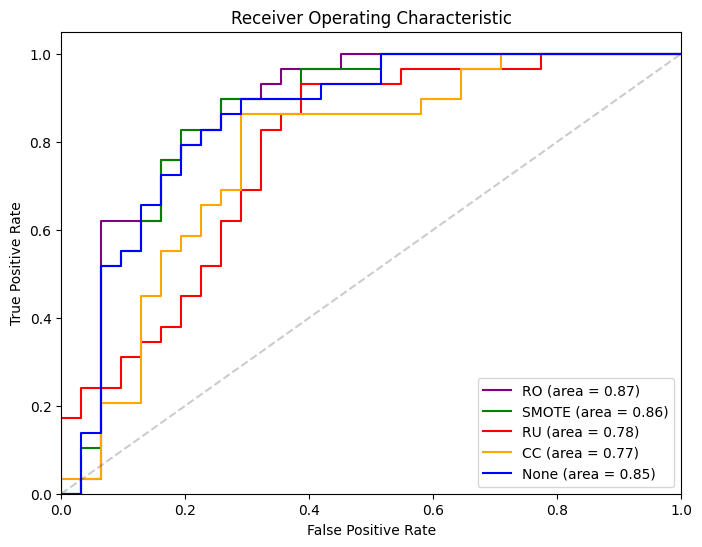

In [16]:
plt.figure(figsize=(8, 6))
colour_idx = 0
colours = ['purple', 'green', 'red','orange','blue']

for name, (best_band,estimator, filter_b_a, best_W) in freqBandEstimators.items():
    probs = cross_val_predict(estimator, testData_motionIntent.iloc[:,:nCols-1], testData_motionIntent.iloc[:,nCols-1], cv=5, method="predict_proba")
    probs = probs[:, 1]  # use the probability of the positive class
    true_labels = testData_motionIntent.iloc[:,nCols-1]

    # Calculate ROC curve and AUC score
    fpr, tpr, thresholds = roc_curve(true_labels, probs)
    auc_score = auc(fpr, tpr)

    # Plot ROC curve for current model
    plt.plot(fpr, tpr, color=colours[colour_idx], label= name + ' (area = %0.2f)' % auc_score)
    colour_idx += 1

    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print(f"{name} resampler optimal threshold : {optimal_threshold}")

plt.plot([0, 1], [0, 1], 'k--',alpha=0.2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [17]:
_, bestEstimator_freq_band, (best_b,best_a), W_freq_band = freqBandEstimators["RO"]


In [18]:
bestEstimator_freq_band


SVC(C=1, class_weight='balanced', gamma=1, kernel='linear', probability=True)

### Person's Correlation Coefficient (PCC) + CSP

In [19]:
# #Plot distributions of channels against eachother
# # to find out if there is any sort of positive correlation
# # between channels

# import seaborn as sns
# import pandas as pd
# from sklearn.preprocessing import StandardScaler
# trialWin = np.arange(int(1.1*sRate),int(3.1*sRate))

# # #get mixed trial data from original
# trials_mixed = np.zeros(
#             (nChannels, len(eventOnsets[0]), len(trialWin)))


# for i, onset in enumerate(eventOnsets[0]):
#     trials_mixed[:,i,:] = eeg[:,onset+trialWin]

# # By augmenting the algorithm outlined in [ref: Electroencephalogram channel selection based on pearson correlation coefficient for motor imagery-brain-computer interface]
# # we can able to extract the most correlated channels in the given data prior to selecting features with the CSP algorithm.


# scaler = StandardScaler()

# # For each trial
# #We must standardize the values in each trial window for each channel (We use z-score normalization for this)
# _, nTrials, _ = trials_mixed.shape

# trialChannelCorrelations = []

# plotFirst = False #flag to check that heatmap of first trial is plotted

# for trial in range(nTrials):

#     zTrial = scaler.fit_transform(trials_mixed[:,trial,:])
#     corrMat = np.corrcoef(zTrial)

#     if not plotFirst:
#         plt.figure(figsize=(15, 16))
#         sns.heatmap(pd.DataFrame(corrMat,columns=channelNames,index=channelNames),cmap="RdYlGn",vmin=-1,vmax=1)
#         plotFirst = True

# #     # We must then calculate the correlation matrices for each trial and return the mean for each row giving, us a vector of mean values
# #     # which represents the average corellation values for a specific channel in relation to other channels.
#     channelCorrValues = {ch:corrMean for (ch,corrMean) in zip(channelNames,np.mean(corrMat,axis=1))}

# #     #Following the above referenced paper, we select the first 14 channels

#     channelCorrValues = dict(sorted(channelCorrValues.items(), key=lambda x:x[1], reverse=True)[:14])
#     trialChannelCorrelations.append(channelCorrValues)


In [20]:
# from collections import defaultdict

# channelOccurences = defaultdict(int)

# for dic in trialChannelCorrelations:
#     for ch, _ in dic.items():
#         channelOccurences[ch] += 1


# channelOccurences = dict(sorted(channelOccurences.items(), key=lambda x:x[1], reverse=True))

# selectedChannels = list(channelOccurences.keys())[:14]
# # #It can be seen that all selected channels are in and around the sensorimotor cortex

# selectedSet = set(selectedChannels)
# selectedIdxs = [idx for idx,ch in enumerate(channelNames) if ch in selectedSet]

# # #Plot heatmap of first trial
# plt.figure(figsize=(10, 8))
# sns.heatmap(pd.DataFrame(np.corrcoef(scaler.fit_transform(trials_mixed[selectedIdxs,0,:])),
#             columns=selectedChannels,
#             index=selectedChannels),
#             cmap="RdYlGn",
#             vmin=-1,
#             vmax=1)


In [21]:
# accVal = 0
# bestAccVal = 0
# bestEstimator_selected_channels = None
# for model in ["Logistic Regression","LDA","SVC"]:
#     accVal, estimator =  testClassifier(dataD,1.1,3.1,0.7,model,b=best_b,a=best_a,selectedChannels=selectedIdxs)
#     print(f"acc val for {model} is {accVal}")
#     if accVal > bestAccVal:
#         bestAccVal = accVal
#         bestEstimator_selected_channels = estimator

# bestAccVal


In [22]:
# bestEstimator_selected_channels


### Calibration of best classifier to predict probability outputs for all time samples

In [23]:
evalDataD = scipy.io.loadmat("BCICIV_1eval_1000Hz_mat/BCICIV_eval_ds1d_1000Hz.mat")


In [24]:
bestEstimator_freq_band


SVC(C=1, class_weight='balanced', gamma=1, kernel='linear', probability=True)

In [25]:
idlesStateClassifier


SVC(C=10, class_weight='balanced', gamma=1, kernel='linear', probability=True)

In [26]:

from sklearn.calibration import CalibratedClassifierCV

bestEstimator_freq_band = CalibratedClassifierCV(bestEstimator_freq_band,cv="prefit")
bestEstimator_freq_band.fit(testData_motionIntent.iloc[:,:nCols-1], testData_motionIntent.iloc[:,nCols-1])


CalibratedClassifierCV(cv='prefit',
                       estimator=SVC(C=1, class_weight='balanced', gamma=1,
                                     kernel='linear', probability=True))

In [27]:
probabilities = startRunningClassifier(evalDataD,bestEstimator_freq_band,idlesStateClassifier,motionIntentComp, idleStateComp,W_freq_band,W_idle_motionIntent,trialWinStart=0,trialWinEnd=4,b=best_b,a=best_a)


In [29]:
import csv

with open("output_subject_d_1000Hz.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(probabilities)
